In [27]:
from models_otimizador import otimizador
import pandas as pd
import json
import pulp
import numpy as np
import logging
import matplotlib.pyplot as plt

%load_ext autoreload
%reload_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Iniciando dados de entrada

Dataframe de entradas

In [28]:
# dataframe com index como datas de 2024-01-01 a 2024-12-31
entradas_df = pd.DataFrame({
    'data': pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')})


entradas_df.head()

,data
0,2024-01-01
1,2024-01-02
2,2024-01-03
3,2024-01-04
4,2024-01-05


Json de entradas

In [29]:
entradas_json = {"indices":{}, "conjuntos":{},"parametros_modelo":{}, "parametros_por_contrato":{}}

# Leitura de dados externos

## Parâmetros de configurações

In [30]:
config = pd.read_csv('entradas/raw/tb_configuracoes.csv', index_col=0)
config.head()

,CH_CATEGORY,CH_TAG,CH_DESCRIPTION,CH_TITLE,NR_VALUE,CH_UNIT,CH_OBSERVATION
CH_ID_CONFIGURATION,,,,,,,
089f0f1d0e7e42919ad33f3e14a920f9,Default de Parâmetros de criação de cenários,TM_BOGCTE,"Tempo máximo, em segundos, de execução da simu...",Tempo máximo de execução para BOG constante (s),600,s,NaN
1c62d914038f46d1af487b895fa43f39,Composição da carga de GNL padrão,NC5,Percentual molar de n-pentano,n-C5,"0,01",%,NaN
1c870480b7e842168c4cc35eed7ecd8b,Parâmetros para simulações,MAX_INVENTORY,Nível máximo do inventário.,Inventário Máx.,165285,m³GNL,NaN
21ad3ca4b7e04b518edb65b1788c8d22,Default de Parâmetros de criação de cenários,K,Custo fixo de recebimento de carga devido à de...,Custo fixo da operação STS,500000,US$,NaN
257ee827771648c89c210c71d9758299,Parâmetros para simulações,GER_DIARIA_UTE_PSI,Capacidade máxima de geração da UTE PS-I,Geração Máx. UTE PS-I,1516,MW,NaN


In [31]:
config[config['CH_CATEGORY']=='Conversões']

,CH_CATEGORY,CH_TAG,CH_DESCRIPTION,CH_TITLE,NR_VALUE,CH_UNIT,CH_OBSERVATION
CH_ID_CONFIGURATION,,,,,,,
3184c351fdfb44be9f0d8f080ccc7686,Conversões,MWH_M3GNL,Conversão de MWh para kg. Média dos dados hist...,Conversão de m³GNL para MWh da UTE-PSI,"3,73",-,NaN
43021964a0ea4b589318ba24738a6fb6,Conversões,KG_SM3,Conversão de Sm³ para kg. Média dos dados hist...,Conversão de Sm³ para Kg,"0,723",-,NaN
5ccf4deb89934875bf6208a616c8981d,Conversões,MJ_KG,Conversão de kg para MJ. Média dos dados histó...,Conversão de Kg para MJ,"54,944",-,NaN
9093168cc74b4535a3e8648dbbb1703a,Conversões,KG_NM3,Conversão de Nm³ para kg. Média dos dados hist...,Conversão de Nm³ para Kg,"0,711",-,NaN
98cecd3df39349968248a6702394bfa5,Conversões,F3_M3,Parâmetro de conversão de m³ para ft³,Conversão de m³ para ft³,"35,147",-,NaN
cb4e32d7f2ab4553b41ef1d88cf4cba2,Conversões,KG_M3GNL,Conversão de m³ de GNL para kg. Média dos dado...,Conversão de m³GNL para Kg,"438,478",-,NaN
de83a7bce245424c8f30e662a98b9446,Conversões,MJ_MMBTU,Parâmetro de conversão de MMBTU para MJ (razão...,Conversão de MMBTU para MJ,"1055,056",-,NaN


In [32]:
MJ_MMBTU = config[config["CH_TAG"] == "MJ_MMBTU"]["NR_VALUE"].values[0]
# replace , for . 
MJ_MMBTU = float(str(MJ_MMBTU).replace(",","."))

KG_M3GNL = config[config["CH_TAG"] == "KG_M3GNL"]["NR_VALUE"].values[0]
# replace , for .
KG_M3GNL = float(str(KG_M3GNL).replace(",","."))

MJ_KG = config[config["CH_TAG"] == "MJ_KG"]["NR_VALUE"].values[0]
# replace , for .
MJ_KG = float(str(MJ_KG).replace(",","."))

M3GNL_MMBTU = (MJ_MMBTU / MJ_KG) * (1 / KG_M3GNL)

MWH_M3GNL = config[config["CH_TAG"] == "MWH_M3GNL"]["NR_VALUE"].values[0]
# replace , for . 
MWH_M3GNL = float(str(MWH_M3GNL).replace(",","."))

KG_NM3 = config[config["CH_TAG"] == "KG_NM3"]["NR_VALUE"].values[0]
# replace , for . 
KG_NM3 = float(str(KG_NM3).replace(",","."))



Valores default para os parâmetros de entrada do modelo

In [33]:
config.loc[config["CH_CATEGORY"]=="Default de Parâmetros de criação de cenários",["CH_TAG","NR_VALUE"]]

,CH_TAG,NR_VALUE
CH_ID_CONFIGURATION,,
089f0f1d0e7e42919ad33f3e14a920f9,TM_BOGCTE,600
21ad3ca4b7e04b518edb65b1788c8d22,K,500000
27420050b5fe47f0846103ac3579301e,S0,0
342d7c0d1b1143e6a0a420d285d1076b,Q2,150000
4eb11ad9adb6493b8d3b2209d3725141,DW,10
58932e6f511142598238ac4aa6928f8d,BOGCTE,1
69cb12c97a00477986d496eba041575f,BG,100
882beb72813c46b8b84b79f0a06b60c7,SMIN_FLEX,1
9ba53e52882d4059b2a3a124e57d7700,TM_BOGLEVEL,1200


## Dados de entrada de preço de GNL 

fonte: https://www.gov.br/mme/pt-br/assuntos/secretarias/petroleo-gas-natural-e-biocombustiveis/publicacoes-1/boletim-mensal-de-acompanhamento-da-industria-de-gas-natural/2024/12-boletim-de-acompanhamento-da-industria-de-gas-natural-dezembro-de-2024.pdf

Dados de jan a dez de 2024
- Spot LNG FOB Brazil  em US$/MMBtu: pag 15
- Petróleo Brent em US$/bbl: pag 15


In [34]:
spot_lng_fob_brazil = [8.35, 12.22, 7.93, 7.92, 27.62, 19.31, 13.51, 13.69, 13.64, 10.19, 9.40, 8.93]
brent_crude_oil = [80.23, 83.76, 85.45,90.05 ,81.75 ,82.25 ,85.15 ,80.36 ,74.02 ,75.63 ,74.35 ,73.86 ]

dolar_data = pd.read_csv('entradas/raw/USD_BRL Dados Históricos.csv',parse_dates=['Data'], dayfirst=True,index_col='Data')
# replace , for . and convert to float
dolar_data['Último'] = dolar_data['Último'].str.replace(',','.').astype(float)
dolar_data.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-12-31,6.1778,"6,1778","6,1778","6,1778",NaN,"0,00%"
2024-12-30,6.1778,"6,2030","6,2428","6,1518",NaN,"-0,30%"
2024-12-27,6.1964,"6,1834","6,2159","6,1693",NaN,"0,22%"
2024-12-26,6.1828,"6,1602","6,1982","6,1462",NaN,"-0,13%"
2024-12-25,6.1906,"6,1906","6,1906","6,1906",NaN,"0,00%"


In [ ]:
# Criar dataframe com índice diário com datas de 2024-01-01 a 2024-12-31
date_range = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
df_price = pd.DataFrame(index=date_range)
# Adicionar dados de entrada ao dataframe repetindo valores mensais para cada dia do mês
df_price['spot_lng_fob_brazil'] = np.repeat(spot_lng_fob_brazil, [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
df_price['brent_crude_oil'] = np.repeat(brent_crude_oil, [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

# adicionar coluna com valor do dólar para cada dia a partir da coluna "último" do dataframe dolar_data
df_price['dolar_brl'] = dolar_data['Último'].resample('D').ffill().reindex(date_range)
df_price.reset_index(inplace=True)
df_price.head()

,spot_lng_fob_brazil,brent_crude_oil,dolar_brl
2024-01-01,8.35,80.23,4.8526
2024-01-02,8.35,80.23,4.9235
2024-01-03,8.35,80.23,4.9198
2024-01-04,8.35,80.23,4.8968
2024-01-05,8.35,80.23,4.8743


In [36]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Freq: D
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   spot_lng_fob_brazil  366 non-null    float64
 1   brent_crude_oil      366 non-null    float64
 2   dolar_brl            366 non-null    float64
dtypes: float64(3)
memory usage: 11.4 KB


# Construção de parâmetros do modelo



## Lista de Símbolos

### Índices e conjuntos

| Símbolo | Descrição |
|---------|-----------|
| $t \in T$ | Index of time periods in the planning horizon |
| $i \in I$ | Index of downstream gas consumers |
| $j \in J$ | Index of LNG procurement contracts |
| $c \in C$ | Index of pricing tiers in SPA contracts |
| $m \in M$ | Index of take-or-pay (ToP) penalty tiers |
| $n \in N$ | Index of inventory intervals for BOG modeling |

### Parâmetros

- Operação da FSRU

| Símbolo | Descrição |
|---------|-----------|
| $\hat{S}_0$ | Initial LNG inventory level (m$^3$) |
| $\hat{S}^{up}$ | Maximum LNG storage capacity of the FSRU (m$^3$) |
| $\hat{S}^{idle}_{lo}$ | Minimum inventory level required during idle operation (m$^3$) |
| $\hat{S}^{prod}_{lo}$ | Minimum inventory level required during regasification (m$^3$) |
| $\hat{I}_t$ | Binary parameter indicating operating mode (1 = idle, 0 = production) |
| $\hat{K}$ | Fixed cost associated with ship-to-ship unloading operation (R\$) |



- Demanda de GNL

| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{d}_{i,t}$ | LNG demand of consumer $i$ in period $t$ (m$^3$) |


-  Contratos de fornecimento de GNL

| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{adp}_{j,t}$ | Scheduled LNG volume under the Annual Delivery Program (ADP) for contract $j$ in period $t$ (m$^3$) |
| $\hat{V}_{j}^{total}$ | Corresponds to the Annual Contract Quantity (ACQ) for contract $j$ |
| $\hat{P}^{spa,price}_{j,c}$ | LNG unit price associated with pricing tier $c$ of contract $j$ (R\$/m$^3$) |
| $\hat{P}^{spa,top}_{j,m}$ | Take-or-pay penalty associated with tier $m$ of contract $j$ (R\$/m$^3$) |
| $\hat{V}^{price,lo}_{j,c}$ | Lower accumulated volume threshold for pricing tier $c$ (m$^3$) |
| $\hat{V}^{price,up}_{j,c}$ | Upper accumulated volume threshold for pricing tier $c$ (m$^3$) |
| $\hat{V}^{top,lo}_{j,m}$ | Lower accumulated canceled volume threshold for ToP tier $m$ (m$^3$) |
| $\hat{V}^{top,up}_{j,m}$ | Upper accumulated canceled volume threshold for ToP tier $m$ (m$^3$) |
| $\hat{P}^{spot}_t$ | Spot LNG price in period $t$ (R\$/m$^3$) |
|$\hat{V}^{spot,lo}$ | Minimum spot volume |
|$\hat{V}^{spot,up}$ | Maximum spot volume |
| $\hat{P}^{dem}$ | Daily demurrage penalty cost (R\$) |
| $ER_t$ | Exchange rate (R\$/US\$) in period $t$ |


- Geração de BOG

| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{bog,lo}_{n}$ | Lower inventory bound of BOG interval $n$ (m$^3$) |
| $\hat{V}^{bog,up}_{n}$ | Upper inventory bound of BOG interval $n$ (m$^3$) |
| $\hat{F}^{bog}_{n}$ | Boil-off rate associated with interval $n$ (-) |
| $\hat{V}^{prod}_{bog}$ | BOG generated during regasification (m$^3$/day) |

- Custo financeiro de imobilização de capital

| Símbolo | Descrição |
|---------|-----------|
| $\hat{R}$ | Interest rate used to represent capital cost (-) |
| $\hat{P}^{cap}$ | Reference LNG price for inventory capitalization (R\$/m$^3$) |




- Outros

| Símbolo | Descrição |
|---------|-----------|
| $\kappa$ | Energy-to-volume conversion factor (MMBtu per m$^3$ of LNG) |

| $\alpha_c$ | Slope coefficient of oil-indexed LNG pricing formula (-) |

### Variáveis

| Símbolo | Descrição |
|---------|-----------|
| $s_t$ | LNG inventory level at the end of period $t$ (m$^3$) |
| $x_t$ | Spot LNG volume procured in period $t$ (m$^3$) |
| $y_{j,t}$ | Binary variable indicating confirmation of SPA cargo $j$ in period $t$ |
| $y^{price}_{j,c,t}$ | Binary variable indicating activation of pricing tier $c$ for contract $j$ in period $t$ |
| $y^{top}_{j,m,t}$ | Binary variable indicating activation of take-or-pay tier $m$ for contract $j$ in period $t$ |
| $y^{bog}_{n,t}$ | Binary variable selecting BOG interval $n$ in period $t$ |
| $b_t$ | Boil-off gas volume generated in period $t$ (m$^3$) |
| $v_t$ | Virtual financial account balance associated with LNG inventory in period $t$ (R\$) |
| $c^{a}_{j,t}$ | Accumulated confirmed volume under contract $j$ up to period $t$ (m$^3$) |
| $c^{c}_{j,t}$ | Accumulated canceled volume under contract $j$ up to period $t$ (m$^3$) |



## Demanda de GNL



| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{d}_{i,t}$ | LNG demand of consumer $i$ in period $t$ (m$^3$) |

A demanda de GNL considera 2 consumidores distintos: o parque termoelétrico e uma distribuidora de gás

A demanda do parque termoelétrico deve considerar uma geração de 1,2 GW todos os dias entre julho e novembro do ano em questão  

Já a distribuidora contratou 3MM de nm³ de gás a serem entregues durante todo o ano

Cálculo da demanda diária dos consumidores

In [38]:
# | $\hat{I}_t$ | Binary parameter indicating operating mode (1 = idle, 0 = production) |

termoeletrica = 1200 * 24 / MWH_M3GNL
print(f"Demanda termoelétrica: 1.2 GW -> {termoeletrica:.2f} m³ de GNL por dia")

# Conversào de 3MM de nm³ de GN para m³ de GNL
GN = 1e6
distribuidora = GN * KG_NM3 / KG_M3GNL
print(f"Demanda distribuidora: 1 MM Nm³ -> {distribuidora:.2f} m³ de GNL por dia")

print(f"Demanda total: {termoeletrica + distribuidora:.2f} m³ de GNL por dia")

Demanda termoelétrica: 1.2 GW -> 7721.18 m³ de GNL por dia
Demanda distribuidora: 1 MM Nm³ -> 1621.52 m³ de GNL por dia
Demanda total: 9342.70 m³ de GNL por dia


Montagem do Parâmetro V_d

In [39]:
# Adicionando ao dataframe entradas a coluna de demanda termoelétrica  (V_d_0) com valor de 7721.18 para o período de julho a novembro de 2024
entradas_df.loc[(entradas_df['data'] >= '2024-07-01') & (entradas_df['data'] <= '2024-11-30'), 'V_d_0'] = termoeletrica
entradas_df.fillna(0, inplace=True)

# Adicionando ao dataframe entradas a coluna de demanda distribuidora (V_d_1) com valor de 1621.52 para todo o ano de 2024
entradas_df['V_d_1'] = distribuidora

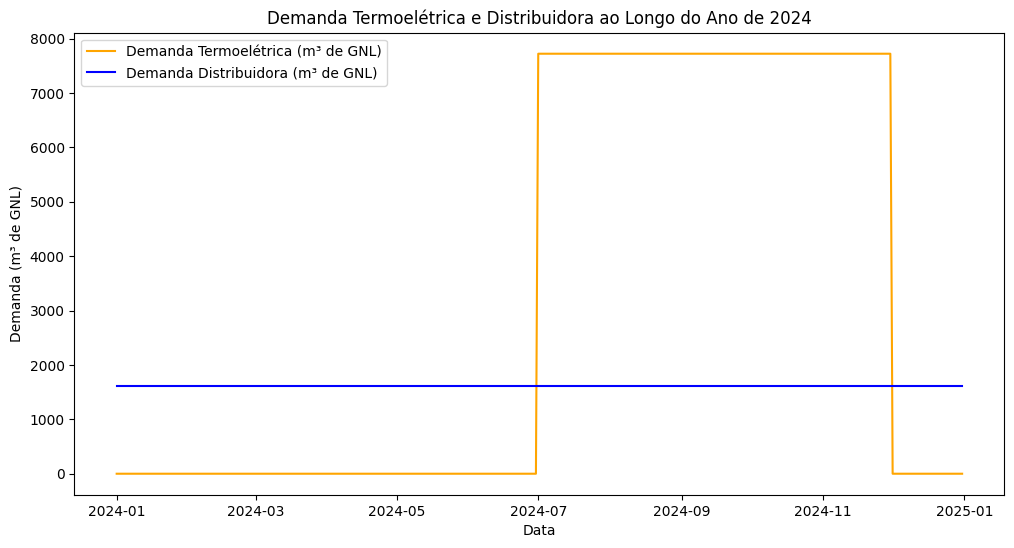

In [40]:
# Plot da demanda termoelétrica e da distribuidora ao longo do ano
plt.figure(figsize=(12, 6))
plt.plot(entradas_df['data'], entradas_df['V_d_0'], label='Demanda Termoelétrica (m³ de GNL)', color='orange')
plt.plot(entradas_df['data'], entradas_df['V_d_1'], label='Demanda Distribuidora (m³ de GNL)', color='blue')
plt.title('Demanda Termoelétrica e Distribuidora ao Longo do Ano de 2024')
plt.xlabel('Data')
plt.ylabel('Demanda (m³ de GNL)')
plt.legend()
plt.show()

## Operação da FSRU



| Símbolo | Descrição |
|---------|-----------|
| $\hat{S}_0$ | Initial LNG inventory level (m$^3$) |
| $\hat{S}^{up}$ | Maximum LNG storage capacity of the FSRU (m$^3$) |
| $\hat{S}^{idle}_{lo}$ | Minimum inventory level required during idle operation (m$^3$) |
| $\hat{S}^{prod}_{lo}$ | Minimum inventory level required during regasification (m$^3$) |
| $\hat{I}_t$ | Binary parameter indicating operating mode (1 = idle, 0 = production) |
| $\hat{K}$ | Fixed cost associated with ship-to-ship unloading operation (R\$) |

In [41]:
S_0 = 12000
S_up = 170000
S_idle_lo = 12000
S_prod_lo = 24000
K = 3000000

S0 -> S_0
S_MAX -> S_up  
S_MIN_IDLE -> S_idle_lo  
S_MIN_PROD -> S_prod_lo

In [42]:
entradas_json["parametros_modelo"].update({
    "S_0": S_0,
    "S_up": S_up,
    "S_idle_lo": S_idle_lo,
    "S_prod_lo": S_prod_lo,
    "K": K})

## Contratos de fornecimento de GNL


- Parâmetros SPA
  
| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{adp}_{j,t}$ | Scheduled LNG volume under the Annual Delivery Program (ADP) for contract $j$ in period $t$ (m$^3$) |
| $\hat{V}_{j}^{total}$ | Corresponds to the Annual Contract Quantity (ACQ) for contract $j$ |
| $\hat{V}_{j}^{ac,0}$ | Initial value of the continuous variable $ca_{j,t}$ represents the accumulated volume of confirmed cargoes under contract $j$ up to period $t$|
| $\hat{V}^{price,lo}_{j,c}$ | Lower accumulated volume threshold for pricing tier $c$ (m$^3$) |
| $\hat{V}^{price,up}_{j,c}$ | Upper accumulated volume threshold for pricing tier $c$ (m$^3$) |
| $\hat{V}_{j}^{cc,0}$ | Initial value of the continuous variable $cc_{j,t}$ represents the accumulated volume of canceled cargoes under contract $j$ up to period $t$|
| $\hat{V}^{top,lo}_{j,m}$ | Lower accumulated canceled volume threshold for ToP tier $m$ (m$^3$) |
| $\hat{V}^{top,up}_{j,m}$ | Upper accumulated canceled volume threshold for ToP tier $m$ (m$^3$) |
| $\hat{P}^{spa,price}_{j,c,t}$ | LNG unit price associated with pricing tier $c$ of contract $j$ (R\$/m$^3$) |
| $\hat{P}^{spa,top}_{j,m,t}$ | Take-or-pay penalty associated with tier $m$ of contract $j$ (R\$/m$^3$) |



- Parâmetros spot
  
| Símbolo | Descrição |
|---------|-----------|
| $\hat{P}^{spot}_t$ | Spot LNG price in period $t$ (R\$/m$^3$) |
|$\hat{V}^{spot,lo}$ | Minimum spot volume |
|$\hat{V}^{spot,up}$ | Maximum spot volume |



- Parâmetros geral
  
| Símbolo | Descrição |
|---------|-----------|
| $\hat{P}^{dem}$ | Daily demurrage penalty cost (R\$) |
| $ER_t$ | Exchange rate (R\$/US\$) in period $t$ |




### Parâmetros do SPA

**Parâmetros de volumes**

O cenário considera apenas 1 contrato SPA de longo prazo em que o ADP foi construído de forma a permitir o fornecimento de até 10 000  m³ de GNL ao dia durante todo o ano.

Dessa forma, o parâmetro V_adp vai contar com a chegada de uma carga de GNL de 150 000 m³ a cada 15 dias

In [43]:
# Adicionando ao dataframe entradas_df a coluna de planejamento de chegada de carga para o contrato 0 (V_adp_0) com valor de 150000 m³ a cada 15 dias a partir de 2024-01-01
for i in range(0, len(entradas_df), 15):
    entradas_df.loc[i, 'V_adp_0'] = 150000
    
entradas_df.fillna(0, inplace=True)

In [44]:
entradas_df.head()

,data,V_d_0,V_d_1,V_adp_0
0,2024-01-01,0.0,1621.518069,150000.0
1,2024-01-02,0.0,1621.518069,0.0
2,2024-01-03,0.0,1621.518069,0.0
3,2024-01-04,0.0,1621.518069,0.0
4,2024-01-05,0.0,1621.518069,0.0


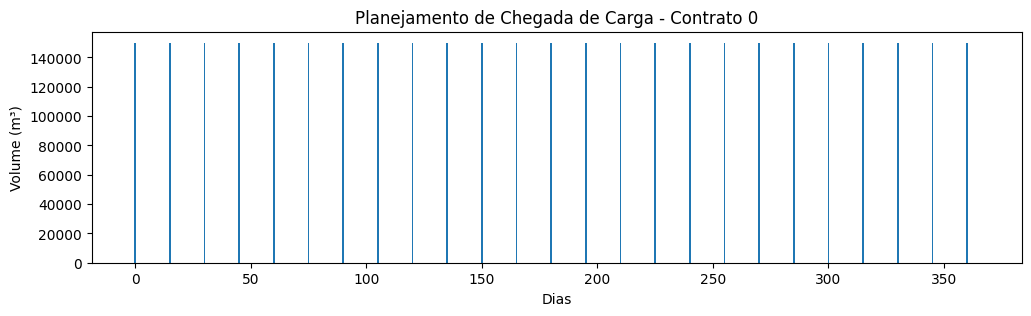

In [45]:
# plot da coluna de planejamento de chegada de carga para o contrato 0 (V_adp_0) ao longo do ano em gráfico de barras
plt.figure(figsize=(12, 3))
plt.bar(entradas_df.index, entradas_df['V_adp_0'])
plt.title('Planejamento de Chegada de Carga - Contrato 0')
plt.xlabel('Dias')
plt.ylabel('Volume (m³)')
plt.grid(False)
plt.show()

O ACQ (V_total) do contrato será o somatório do total planejado no V_adp

O take or pay considera que ao menos 60% desse total deve ser comprado, caso ocntrário, deverá se pagar por carga cancelada mesmo sem receber

O preço possui 2 patamares, com um desconto caso seja comprado mais que 30% do total

In [89]:
V_total = float(entradas_df["V_adp_0"].sum())

V_total*0.6
V_top_lo = [0, V_total*0.6]
V_top_up = [V_total*0.6, V_total]

V_price_lo = [0, V_total*0.3]
V_price_up = [V_total*0.3, V_total]

VT -> V_total  
TPH -> V_top_up  
TPL -> V_top_lo  
LCH -> V_price_up  
LCL -> V_price_lo  
CC_INI -> V_cc_0  
CA_INI -> V_ac_0  



In [90]:
entradas_json["parametros_por_contrato"]["0"] = {
    "V_total": V_total,
    "V_cc_0": 0,
    "V_ca_0": 0,
    "V_top_up": V_top_up, 
    "V_top_lo": V_top_lo,
    "V_price_up": V_price_up,
    "V_price_lo": V_price_lo
}

**Parâmetros de preço**


A equação abaixo demonstra o cálculo básico para a precificação de contratos SPA  
$P_{\text{LNG}} = A \cdot P_{\text{crude oil}} + B$

Será considerado para o cenário o valor do Brent como crude oil index.  
Para o primeiro patamar do LNG pricing A = 13% e B = 0.  
Para o segunto patamar, A = 12% e B = 0  

In [69]:
# Adicionando ao entradas_df a coluna de preço do contrato 0, tier 0 (P_spa_price_0_0) com o valor de brent_crude_oil multiplicado por 13%
entradas_df['P_spa_price_0_0'] = df_price['brent_crude_oil'] * 0.13
# Convertendo esse valor de US$/MMBTU para R$/m³ de GNL usando o valor do dólar e a conversão de MMBTU para m³ de GNL   
entradas_df['P_spa_price_0_0'] = entradas_df['P_spa_price_0_0'] * df_price['dolar_brl'] / M3GNL_MMBTU


# Adicionando ao entradas_df a coluna de preço do contrato 0, tier 1 (P_spa_price_0_1) com o valor de brent_crude_oil multiplicado por 12%
entradas_df['P_spa_price_0_1'] = df_price['brent_crude_oil'] * 0.12
# Convertendo esse valor de US$/MMBTU para R$/m³ de GNL usando o valor do dólar e a conversão de MMBTU para m³ de GNL   
entradas_df['P_spa_price_0_1'] = entradas_df['P_spa_price_0_1'] * df_price['dolar_brl'] / M3GNL_MMBTU

Há também o custo do take or pay que é nulo para o primeiro patamar e acompanha o P_spa_price_0_0 no segundo patamar

In [70]:
entradas_df['P_spa_top_0_0'] = 0
entradas_df['P_spa_top_0_1'] = df_price['brent_crude_oil'] * 0.13

In [72]:
entradas_df.head()

,data,V_d_0,V_d_1,V_adp_0,P_spa_price_0_0,P_spa_price_0_1,P_spa_top_0_0,P_spa_top_0_1,P_spot
0,2024-01-01,0.0,1621.518069,150000.0,1155.705575,1066.805146,0,10.4299,925.238167
1,2024-01-02,0.0,1621.518069,0.0,1172.591271,1082.391942,0,10.4299,938.756566
2,2024-01-03,0.0,1621.518069,0.0,1171.710071,1081.578527,0,10.4299,938.051093
3,2024-01-04,0.0,1621.518069,0.0,1166.232342,1076.522162,0,10.4299,933.665716
4,2024-01-05,0.0,1621.518069,0.0,1160.873694,1071.575717,0,10.4299,929.375674


### Parâmetros do spot

O preço spot considera o valor do spot FOB brazil, que é convertido para R$/m³ de GNL

In [ ]:
entradas_df["P_spot"] = df_price["spot_lng_fob_brazil"] * df_price["dolar_brl"] / M3GNL_MMBTU
entradas_df.head()

,data,V_d_0,V_d_1,V_adp_0,P_spa_price_0_0,P_spa_price_0_1,P_spa_top_0_0,P_spa_top_0_1,P_spot
0,2024-01-01,0.0,1621.518069,150000.0,1155.705575,1066.805146,0,10.4299,925.238167
1,2024-01-02,0.0,1621.518069,0.0,1172.591271,1082.391942,0,10.4299,938.756566
2,2024-01-03,0.0,1621.518069,0.0,1171.710071,1081.578527,0,10.4299,938.051093
3,2024-01-04,0.0,1621.518069,0.0,1166.232342,1076.522162,0,10.4299,933.665716
4,2024-01-05,0.0,1621.518069,0.0,1160.873694,1071.575717,0,10.4299,929.375674


Parâmetros de limite de volume para a compra spot   
V_spot_lo = 30000  
V_spot_up = 150000  

In [85]:
entradas_json["parametros_modelo"]["V_spot_lo"] = 30000
entradas_json["parametros_modelo"]["V_spot_up"] = 150000

In [91]:
entradas_json

{'indices': {},
 'conjuntos': {},
 'parametros_modelo': {'S_0': 12000,
  'S_up': 170000,
  'S_idle_lo': 12000,
  'S_prod_lo': 24000,
  'K': 3000000,
  'P_dem': 1500000.0,
  'V_spot_lo': 30000,
  'V_spot_up': 150000},
 'parametros_por_contrato': {'0': {'V_total': 3750000.0,
   'V_cc_0': 0,
   'V_ca_0': 0,
   'V_top_up': [2250000.0, 3750000.0],
   'V_top_lo': [0, 2250000.0],
   'V_price_up': [1125000.0, 3750000.0],
   'V_price_lo': [0, 1125000.0]}}}

### Gráfico dos preços

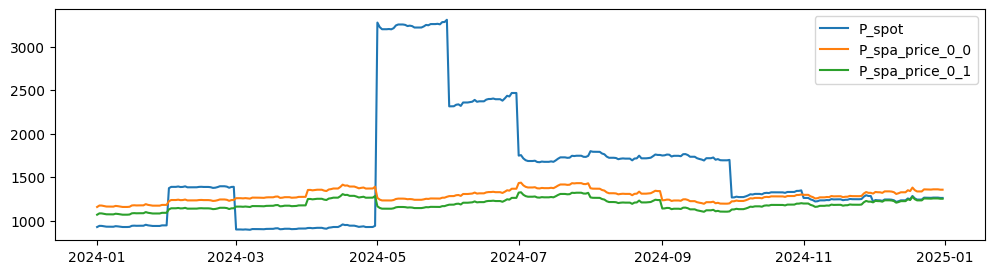

In [75]:
# plot de preços P_spa_price e P_spot ao longo do ano
plt.figure(figsize=(12,3))
plt.plot(entradas_df["data"], entradas_df["P_spot"], label="P_spot")
plt.plot(entradas_df["data"], entradas_df["P_spa_price_0_0"], label="P_spa_price_0_0")
plt.plot(entradas_df["data"], entradas_df["P_spa_price_0_1"], label="P_spa_price_0_1")
plt.legend()
plt.show()

### Parâmetros gerais

In [81]:
# adicionando valor do dolar ao dataframe entradas_df
entradas_df["ER"] = df_price["dolar_brl"]

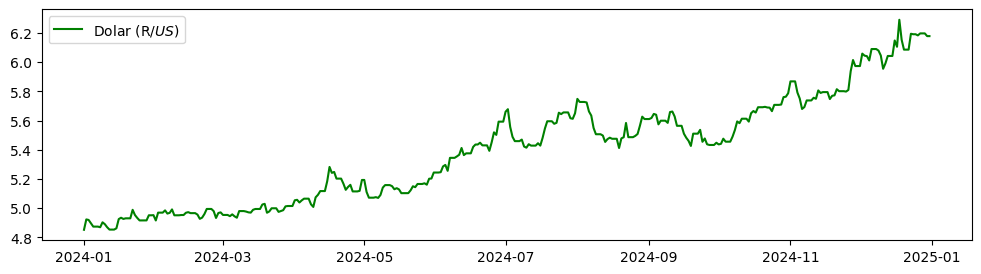

In [83]:
# plot do dolar ao longo do ano
plt.figure(figsize=(12,3))
plt.plot(df_price["index"],df_price["dolar_brl"], label="Dolar (R$/US$)", color='green')
plt.legend()
plt.show()

In [84]:
# adicionando o custo de demurrage por dia de atraso
entradas_json["parametros_modelo"]["P_dem"] = 1.5e6

In [92]:
entradas_df

,data,V_d_0,V_d_1,V_adp_0,P_spa_price_0_0,P_spa_price_0_1,P_spa_top_0_0,P_spa_top_0_1,P_spot,ER
0,2024-01-01,0.0,1621.518069,150000.0,1155.705575,1066.805146,0,10.4299,925.238167,4.8526
1,2024-01-02,0.0,1621.518069,0.0,1172.591271,1082.391942,0,10.4299,938.756566,4.9235
2,2024-01-03,0.0,1621.518069,0.0,1171.710071,1081.578527,0,10.4299,938.051093,4.9198
3,2024-01-04,0.0,1621.518069,0.0,1166.232342,1076.522162,0,10.4299,933.665716,4.8968
4,2024-01-05,0.0,1621.518069,0.0,1160.873694,1071.575717,0,10.4299,929.375674,4.8743
...,...,...,...,...,...,...,...,...,...,...
361,2024-12-27,0.0,1621.518069,0.0,1358.578292,1254.072269,0,9.6018,1263.523938,6.1964
362,2024-12-28,0.0,1621.518069,0.0,1358.578292,1254.072269,0,9.6018,1263.523938,6.1964
363,2024-12-29,0.0,1621.518069,0.0,1358.578292,1254.072269,0,9.6018,1263.523938,6.1964
364,2024-12-30,0.0,1621.518069,0.0,1354.500189,1250.307867,0,9.6018,1259.731164,6.1778


## Geração de BOG



| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{bog,lo}_{n}$ | Lower inventory bound of BOG interval $n$ (m$^3$) |
| $\hat{V}^{bog,up}_{n}$ | Upper inventory bound of BOG interval $n$ (m$^3$) |
| $\hat{F}^{bog}_{n}$ | Boil-off rate associated with interval $n$ (-) |
| $\hat{V}^{prod}_{bog}$ | BOG generated during regasification (m$^3$/day) |

Seguindo a premissa de 1 tanque menor de 26000 m³ e 3 tanques grandes de 48000 m³, totalizando 170 000 m³ de GNL na FSRU e com uma taxa de geração de BOG de 0.12%, a seguir o cálculo dos patamares de geração de bog

In [122]:
V_small = 26000.
V_big = 48000.

V_bog_lo = [0, V_small, V_big, V_small+V_big, 2*V_big,  V_small+ 2* V_big, 3* V_big]
V_bog_up = [ V_small, V_big, V_small+V_big, 2*V_big,  V_small+ 2* V_big, 3* V_big,  V_small+ 3* V_big]
F_bog = [round(v * 0.0012) for v in V_bog_up]



In [123]:
entradas_json["parametros_modelo"]["V_bog_lo"] = V_bog_lo
entradas_json["parametros_modelo"]["V_bog_up"] = V_bog_up
entradas_json["parametros_modelo"]["F_bog"] = F_bog

## Custo financeiro de imobilização de capital

| Símbolo | Descrição |
|---------|-----------|
| $\hat{R}$ | Interest rate used to represent capital cost (-) |
| $\hat{P}^{cap}$ | Reference LNG price for inventory capitalization (R\$/m$^3$) |


O interest rate $\hat{R}$ será baseado em um WACC fictício de 10% aa  
Já para o $\hat{P}^{cap}$ será considerado o menor valor do preço spot para o ano de 2024

In [113]:
R = 0.10
entradas_json["parametros_modelo"]["R"] = R

P_cap = float(entradas_df["P_spot"].min())
entradas_json["parametros_modelo"]["P_cap"] = P_cap

# Adicionando entradas ao cenário

Adicionando índices

In [124]:
T = len(entradas_df)
I = 2
J = 2
M = 2
C = 2
N = 7

entradas_json["indices"]["T"] = T
entradas_json["indices"]["I"] = I
entradas_json["indices"]["J"] = J
entradas_json["indices"]["M"] = M  
entradas_json["indices"]["C"] = C
entradas_json["indices"]["N"] = N

In [125]:
entradas_json

{'indices': {'T': 366, 'I': 2, 'J': 2, 'M': 2, 'C': 2, 'N': 7},
 'conjuntos': {},
 'parametros_modelo': {'S_0': 12000,
  'S_up': 170000,
  'S_idle_lo': 12000,
  'S_prod_lo': 24000,
  'K': 3000000,
  'P_dem': 1500000.0,
  'V_spot_lo': 30000,
  'V_spot_up': 150000,
  'V_bog_lo': [0, 26000.0, 48000.0, 74000.0, 96000.0, 122000.0, 144000.0],
  'V_bog_up': [26000.0,
   48000.0,
   74000.0,
   96000.0,
   122000.0,
   144000.0,
   170000.0],
  'F_bog': [31, 58, 89, 115, 146, 173, 204],
  'R': 0.1,
  'P_cap': 893.620070426087},
 'parametros_por_contrato': {'0': {'V_total': 3750000.0,
   'V_cc_0': 0,
   'V_ca_0': 0,
   'V_top_up': [2250000.0, 3750000.0],
   'V_top_lo': [0, 2250000.0],
   'V_price_up': [1125000.0, 3750000.0],
   'V_price_lo': [0, 1125000.0]}}}

In [ ]:
# Adicionando entradas_json em entradas/entradas.json como mais uma entrada chamada "Cen2"

    
with open("entradas/entradas.json", "r", encoding="utf-8") as f:
    dados = json.load(f)
    
dados["Cen2"] = entradas_json

json.dump(dados, open("entradas/entradas.json", "w"), indent=4, ensure_ascii=False)


In [132]:
# Adicionando entradas_df ao entradas/entradas.xlsx como mais uma aba chamada "Cen2"
with pd.ExcelWriter("entradas/entradas.xlsx", mode="a", engine="openpyxl") as writer:
    entradas_df.to_excel(writer, sheet_name="Cen2", index=False)